In [2]:
# Importing PlaidML. Make sure you follow this 
try:
    import os
    import plaidml.keras
    plaidml.keras.install_backend()
    os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
    from keras import backend as K
    # example of training a gan on mnist
    import keras
    from keras.optimizers import Adam
    from keras import Sequential
    from keras import layers
    from keras.layers import Dense
    from keras.layers import Reshape
    from keras.layers import Flatten
    from keras.layers import Conv2D
    from keras.layers import Conv2DTranspose, MaxPooling2D, UpSampling2D, ZeroPadding2D, Cropping2D
    from keras.layers import LeakyReLU
    from keras.layers import Dropout
    from keras.models import load_model
    from keras.callbacks import EarlyStopping
    from keras.callbacks import ModelCheckpoint
    #------------------------------
    print("Running on MAC OS")
except:
    from tensorflow.keras.optimizers import Adam
    from tensorflow import keras
    from tensorflow.keras import Sequential
    from tensorflow.keras import layers
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.layers import Reshape
    from tensorflow.keras.layers import Flatten
    from tensorflow.keras.layers import Conv2D
    from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, UpSampling2D, ZeroPadding2D, Cropping2D
    from tensorflow.keras.layers import LeakyReLU
    from tensorflow.keras.layers import Dropout
    from tensorflow.keras.models import load_model
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.callbacks import ModelCheckpoint
    from tensorflow.keras.optimizers import Adam
    print("Running on Server/PC")
    #------------------------------------------

Running on Server/PC


In [3]:

import os
from os.path import exists as file_exists    

# Libraries
import glob
import csv
import json
import math
import joblib
#------------------------------
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# import visualkeras

# Metric
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler 
#------------------------------

import scipy
import scipy.cluster.hierarchy as sch


# %%
# Creating two lists of ambient and attack datasets
cur_dir= os.getcwd()
dataset = 'syncan'
# dataset = 'road'


ambient_dirs = glob.glob(cur_dir+f"//..//data//{dataset}//generated//ambients//*.csv")
attack_dirs = glob.glob(cur_dir+f"//..//data//{dataset}//generated//attacks//*.csv")

# Creating two lists of file names 
ambient_files = [x.split("/")[-1].split(".")[0][0:-10] for x in ambient_dirs]
attack_files = [x.split("/")[-1].split(".")[0][0:-10] for x in attack_dirs]

print(f"Ambient files are:\n {ambient_files[0:]}, etc.")
print(f"Attack files are:\n {attack_files[0:]}, etc.")

# %%
ambient_files

# %%
# Defining parameters...........

Ambient files are:
 ['train_2', 'train_1', 'train_3', 'train_4'], etc.
Attack files are:
 ['test_suppress', 'test_flooding', 'test_playback', 'test_continuous', 'test_plateau'], etc.


['train_2', 'train_1', 'train_3', 'train_4']

In [23]:
try:
    import plaidml.keras
    plaidml.keras.install_backend()
    import os
    os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
except:
    import os
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [5]:
noOfSignals = 20
num_signals = noOfSignals
time_step = 50

## Setup

In [6]:
# %%
# Defining functions..............................
#-----------------------------------------------
def sigmoid(x):
    return 1/(1+np.exp(-x))
#-----------------------------------------------
def create_x_sequences(X_values, time_step, window_step, sampling_period):
    X_output = []
    
    for i in range(0, (len(X_values) - sampling_period*time_step), window_step):
        X_output.append(X_values[i : (i + sampling_period*time_step) : sampling_period])
    return np.stack(X_output).reshape(-1, time_step, noOfSignals, 1)


#-----------------------------------------------
def create_y_sequences(y_values, time_step, window_step, sampling_period):
    y_output = []
    
    for i in range(0, (len(y_values) - sampling_period*time_step), window_step):
        if y_values[i : (i + sampling_period*time_step)].sum() > 0:
            y_output.append(1)
        else:
            y_output.append(0)
    return np.stack(y_output)

#--------------- Create Folders -------------
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Detectory created!\n{directory}")
#--------------------------------------

#--------------- Create Folders -------------
def get_minmax_scaler(columns):
    df_min_max = pd.read_csv(f"Scalling_Data/min_max_values_{dataset}.csv", index_col=0)[columns]
    scaler = MinMaxScaler()
    scaler.fit(df_min_max.values)
    print("scaler loaded...!")
    return scaler
#--------------------------------------


def get_encoder_decoder(time_step):
    
#     n_filters_list = [16, 8, 8]
#     n_filters_list = [16, 16, 8] #version = 'v2'
#     n_filters_list = [32, 16, 8] #version = 'v3'
#     n_filters_list = [32, 16, 16] #version = 'v4'
    n_filters_list = [32, 32, 16] #version = 'v5'


    crop_factors = {}
    crop_factors [8] = ((0, 0), (2, 2))
    crop_factors [28] = ((2, 2), (2, 2))
    crop_factors [16] = ((0, 0), (2, 2))
    crop_factors [32] = ((0, 0), (2, 2))
    crop_factors [64] = ((0, 0), (2, 2))
    crop_factors [128] = ((0, 0), (2, 2))


    input_img = keras.Input(shape=(time_step, num_signals, 1))    
    x = input_img
    for n_filters in n_filters_list:    
        x = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
    encoder = keras.Model(input_img, x)


    # encoded_img = keras.Input(shape= x.shape[1][1:])  
    encoded_img = keras.Input(shape= x.shape[1:])  
    x = encoded_img
    # x = keras.layers.Reshape((2, 2, 4))(x)
    for n_filters in n_filters_list[::-1]:    
        x = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)

    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    decoded = layers.Cropping2D(cropping= crop_factors [time_step])(x)
    decoder = keras.Model(encoded_img, decoded)
    return encoder, decoder

def get_autoconder(encoder, decoder):

    # define input to the model:
    x = keras.Input(shape=(time_step, num_signals, 1))
    # make the model:
    autoencoder = keras.Model(x, decoder(encoder(x)))

    # compile the model:
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    autoencoder.summary()
    # compile autoencoder
#     opt = Adam(lr = 0.0002, beta_1=0.5, beta_2=0.99)
#     autoencoder.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
#     autoencoder.summary()
    return autoencoder


In [7]:
input_img = keras.Input(shape=(time_step, num_signals, 1))    
x = input_img
x.shape

TensorShape([None, 50, 20, 1])

In [8]:
version = 'v6'

In [9]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [10]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=0)

In [11]:
history = autoencoder.fit(x_train, x_train,
                epochs=1,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test), callbacks=[es])

# fit model
# history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=4000, verbose=0, callbacks=[es])
# evaluate the model

NameError: name 'autoencoder' is not defined

In [12]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [13]:
history.history

NameError: name 'history' is not defined

In [14]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

NameError: name 'encoder' is not defined

In [15]:
plt.imshow(encoded_imgs[0].reshape(4,-1))

NameError: name 'encoded_imgs' is not defined

In [16]:
#**************** Loading SynCAN Data **********************

In [17]:
# time_step = 64
# encoder, decoder = get_encoder_decoder(time_step)
# autoencoder = get_autoconder(encoder, decoder)
# encoder.summary()
# decoder.summary()

In [18]:
if dataset == 'syncan':
    # signals_in_cluster = ['Sig_2_of_ID_7',
    # 'Sig_2_of_ID_1',
    # 'Sig_1_of_ID_3',
    # 'Sig_2_of_ID_10',
    # 'Sig_2_of_ID_6',
    # 'Sig_1_of_ID_8',
    # 'Sig_3_of_ID_2',
    # 'Sig_1_of_ID_5',
    # 'Sig_1_of_ID_4',
    # 'Sig_1_of_ID_6',
    # 'Sig_2_of_ID_5',
    # 'Sig_3_of_ID_10',
    # 'Sig_2_of_ID_3',
    # 'Sig_1_of_ID_2',
    # 'Sig_1_of_ID_7',
    # 'Sig_2_of_ID_2',
    # 'Sig_1_of_ID_1',
    # 'Sig_4_of_ID_10',
    # 'Sig_1_of_ID_10',
    # 'Sig_1_of_ID_9']
    signals_in_cluster = ['Sig_1_of_ID_2',
        'Sig_1_of_ID_7',
        'Sig_2_of_ID_3',
        'Sig_1_of_ID_10',
        'Sig_1_of_ID_9',
        'Sig_1_of_ID_1',
        'Sig_4_of_ID_10',
        'Sig_2_of_ID_2',
        'Sig_3_of_ID_10',
        'Sig_1_of_ID_6',
        'Sig_2_of_ID_5',
        'Sig_1_of_ID_4',
        'Sig_1_of_ID_5',
        'Sig_3_of_ID_2',
        'Sig_1_of_ID_8',
        'Sig_2_of_ID_6',
        'Sig_2_of_ID_10',
        'Sig_2_of_ID_7',
        'Sig_2_of_ID_1',
        'Sig_1_of_ID_3']

    

# Selected signals...........
noOfSignals = len(signals_in_cluster)
print("noOfSignals: ", noOfSignals)

signals_in_cluster

noOfSignals:  20


['Sig_1_of_ID_2',
 'Sig_1_of_ID_7',
 'Sig_2_of_ID_3',
 'Sig_1_of_ID_10',
 'Sig_1_of_ID_9',
 'Sig_1_of_ID_1',
 'Sig_4_of_ID_10',
 'Sig_2_of_ID_2',
 'Sig_3_of_ID_10',
 'Sig_1_of_ID_6',
 'Sig_2_of_ID_5',
 'Sig_1_of_ID_4',
 'Sig_1_of_ID_5',
 'Sig_3_of_ID_2',
 'Sig_1_of_ID_8',
 'Sig_2_of_ID_6',
 'Sig_2_of_ID_10',
 'Sig_2_of_ID_7',
 'Sig_2_of_ID_1',
 'Sig_1_of_ID_3']

In [24]:
# %%
#-----------------------
time_steps = [16]
window_step = 17
sampling_periods = [1, 5, 10, 20, 50]
training_samples = 1

#-----------------------
# transfer = False

# %%
#------------------------------
training_files = ambient_files[:]
training_dirs = ambient_dirs[:]

# %%
#-----------------------
ensure_dir("AE_Models//")
ensure_dir("Scalling_Data//")
ensure_dir(f"plots//{dataset}//")


In [25]:
unique_IDs = [int(sig.split("_")[-1]) for sig in signals_in_cluster]
num_signals = 20

In [26]:
def vis_ae(save = True):
    # Visualizing the training performance...........
    print("------------- Showing reconstruction example -----------")
    input_image = x_train_seq[0:1].copy()
    output_image = autoencoder.predict(input_image)
    recon_loss = np.abs(output_image - input_image)

    #------- Ploting the data -------------------
    fig, axes = plt.subplots(1, 3, figsize = (12, 4))

    sns.heatmap(input_image[0,:,:,0], ax = axes [0], vmin = 0, vmax = 1)
    axes[0].set_title("input_image")
    sns.heatmap(output_image[0,:,:,0], ax = axes[1], vmin = 0, vmax = 1)
    axes[1].set_title("output_image")
    sns.heatmap(recon_loss[0,:,:,0], ax = axes[2], vmin = 0, vmax = 1)
    axes[2].set_title("recon_loss")
    plt.tight_layout()
    if save:
        plt.savefig(f"plots//{dataset}//Training_Loss_{key_key}.jpg", dpi = 350)
    plt.show()
    #-----------------------------------------------------

time_step:  16  sampling_period: 1
Initialzing transfer learning......
We got something....
No model was found!!!!
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 16, 20, 1)]       0         
                                                                 
 model_1 (Functional)        (None, 2, 3, 16)          14192     
                                                                 
 model_2 (Functional)        (None, 16, 20, 1)         16497     
                                                                 
Total params: 30,689
Trainable params: 30,689
Non-trainable params: 0
_________________________________________________________________
Training from the scratch.....
Loading dataset:  16_1_0_train_2_True_v6
train_2 onboarded!
Before :  (7417431, 23)
No treatment needed for SynCAN!
scaler loaded...!
Creating sequences....
Training input s

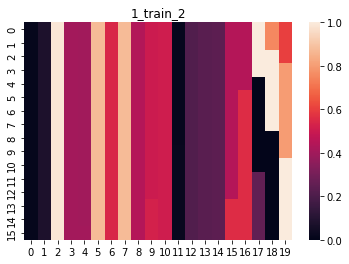

------------- Starting the training process----------------
------------- Showing reconstruction example -----------
1/1 [==============================] - 0s 130ms/step


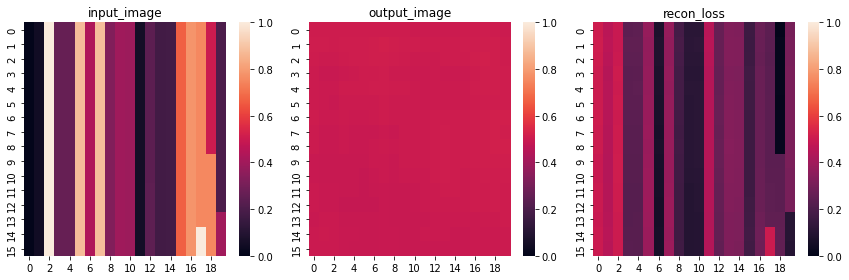

Epoch 1/1000
 418/3068 [===>..........................] - ETA: 55s - loss: 0.4733 - accuracy: 0.1664

KeyboardInterrupt: 

In [27]:
#------- Initilizing models/loading model-------------
#-------- Transfering the model-------------------------------
for transfer in [True]:
    for time_step in time_steps:
        for sampling_period in sampling_periods:
            print("time_step: ", time_step, " sampling_period:", sampling_period)

            if transfer == True:

                #Check for existing model............................
                print("Initialzing transfer learning......")
                #.................  Loading existing trained model ................
                sampling_period_to_look = sampling_period
                while(True):
                    checkpoint_path_to_look = f"AE_Models//{dataset}//autoendoer_canshield_{version}_{dataset}_{time_step}_1_{sampling_period_to_look}_{transfer}.h5"

                    if file_exists(checkpoint_path_to_look) or sampling_period_to_look <= 1:
                        print("We got something....")
                        try:
                            autoencoder = load_model(checkpoint_path_to_look)
                            print(f"Loading the pre-trained model...{checkpoint_path_to_look}")
                        except:
                            print("No model was found!!!!")
                            encoder, decoder = get_encoder_decoder(time_step)
                            autoencoder = get_autoconder(encoder, decoder)
                            print("Training from the scratch.....") 
                        break
                    else:
                        print(f"Model does not exit.")
                        sampling_period_to_look -= 5 if sampling_period_to_look > 5 else 1
                        print(f"Looking for the next model..{sampling_period_to_look}")
                        
            if transfer == False:
                #Start a new network............................
                print("Transfer False")
                encoder, decoder = get_encoder_decoder(time_step)
                autoencoder = get_autoconder(encoder, decoder)
                print("Training from the scratch.....") 
            #.................................................................

            #Loading datasets..................................
            # reading each dataset in a df file
            for file_indx, (file_name, file_dir) in enumerate(zip(training_files, training_dirs)):
                key_key = f'{time_step}_{sampling_period}_{file_indx}_{file_name}_{transfer}_{version}'

                if file_exists(f"Saved_Data//history_{key_key}.json"):
                    print('Already Trained')
                    continue   
                
                try:
                    del X_train
                except:
                    pass
                
                print("Loading dataset: ",key_key)
                # Checking if the signalwise data already exists
                X_train = pd.read_csv(file_dir, index_col = 0) 
                print(f"{file_name} onboarded!")
                print("Before : ", X_train.shape)

                # Defining the number of signals..............................
                num_of_train_samples = int(X_train.shape[0]*training_samples)

                X_train = X_train.iloc[0:num_of_train_samples].copy()
                X_train = X_train[signals_in_cluster].astype(float).copy()

                if dataset == 'road':
                    # Forward filling algorithm........
                    print("Forward filling...")
                    X_train = X_train.ffill().copy()
                    X_train = X_train.bfill().dropna()   
                    #--------------------------------
                    print("X_train.shape", X_train.shape)
                    print("Done data treatment..")
                    #------------------------------------
                else:
                    print("No treatment needed for SynCAN!")

                #Scaling dataset..................................
                X_train = X_train.values.copy()  
                scaler_train = get_minmax_scaler(signals_in_cluster)
                X_train = scaler_train.transform(X_train).copy()

                # Creating sequences...........................................
                print("Creating sequences....")
                x_train_seq = create_x_sequences(X_train, time_step, window_step, sampling_period).copy()
                print("Training input shape: ", x_train_seq.shape)

                max_epoch = 1000

                print("Max_epoch: ", max_epoch)

                #-----------------------------------------------------------
                plt.figure()
                sns.heatmap(x_train_seq[100,:,:,0])
                plt.title(f"{sampling_period}_{file_name}")
                plt.show()
                #-----------------------------------------------------------


                #----------------  Starting the training--------------------
                #.......................... Training the model ....................
                print("------------- Starting the training process----------------")
                checkpoint_path = f"AE_Models//{dataset}//autoendoer_canshield_{version}_{dataset}_{time_step}_1_{sampling_period}_{transfer}.h5"

                #----------- Defining Callback-------------------------------------
                keras_callbacks   = [
                      EarlyStopping(monitor='val_loss', patience=10, mode='min'),
                      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only = True, mode='auto', verbose=1)
                ]
                #----------------------------------------------------------------

                # Pretraining visulization.......................................
                vis_ae(save = False)
                # Initializing the training.......................................
                history = autoencoder.fit(
                    x_train_seq,
                    x_train_seq,
                    epochs=max_epoch ,
                    batch_size=128,
                    validation_split=0.1,
                    callbacks=keras_callbacks
                )

                #Saving data.........................................................
                with open(f"Saved_Data//history_{key_key}.json", "w") as outfile:
                    json.dump(history.history, outfile)

    #             autoencoder.save(checkpoint_path)
                #-------------------------------------------------------------------
                print("------------------------ Done ------------------------")

                # Visualizing the training performance...........
                # Post-training visulization.......................................
                vis_ae(save = True)

------------------------ Done ------------------------
------------- Showing reconstruction example -----------
1/1 [==============================] - 0s 12ms/step


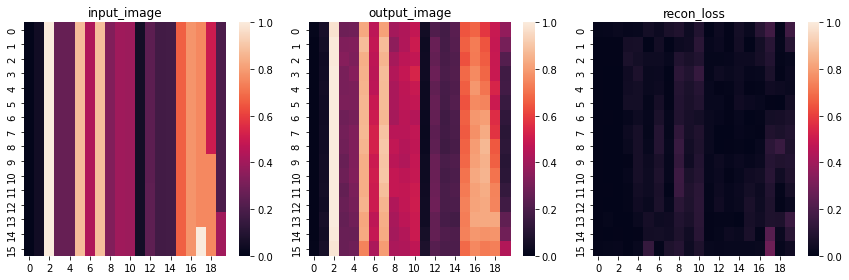

In [28]:
#-------------------------------------------------------------------
print("------------------------ Done ------------------------")

# Visualizing the training performance...........
print("------------- Showing reconstruction example -----------")
input_image = x_train_seq[0:1].copy()
output_image = autoencoder.predict(input_image)
recon_loss = np.abs(output_image - input_image)

#------- Ploting the data -------------------
fig, axes = plt.subplots(1, 3, figsize = (12, 4))

sns.heatmap(input_image[0,:,:,0], ax = axes [0], vmin = 0, vmax = 1)
axes[0].set_title("input_image")
sns.heatmap(output_image[0,:,:,0], ax = axes[1], vmin = 0, vmax = 1)
axes[1].set_title("output_image")
sns.heatmap(recon_loss[0,:,:,0], ax = axes[2], vmin = 0, vmax = 1)
axes[2].set_title("recon_loss")
plt.tight_layout()
plt.show()
#-----------------------------------------------------

In [31]:
img = input_image[0]
 
print('Original Dimensions : ',img.shape)
 
# width = 20
# height = img.shape[0] # keep original height
# dim = (width, height)

width = 20
height = 20 # keep original height
dim = (width, height)
 
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
 
print('Resized Dimensions : ',resized.shape)
 
plt.imshow(resized)
plt.show()

Original Dimensions :  (16, 20, 1)


NameError: name 'cv2' is not defined

------------------------ Done ------------------------
------------- Showing reconstruction example -----------
1/1 [==============================] - 0s 12ms/step


ValueError: Must pass 2-d input. shape=(16, 20, 1)

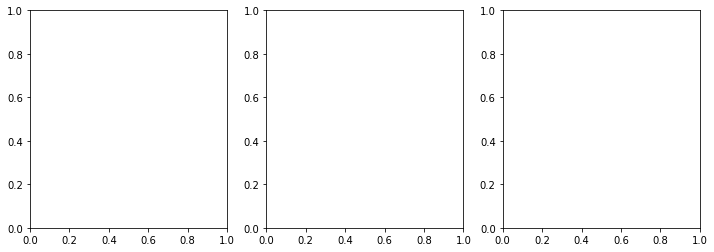

In [33]:
#-------------------------------------------------------------------
print("------------------------ Done ------------------------")

# Visualizing the training performance...........
print("------------- Showing reconstruction example -----------")
input_image = x_train_seq[0:1].copy()


output_image = autoencoder.predict(input_image)
recon_loss = np.abs(output_image - input_image)

input_image = cv2.resize(input_image[0], dim, interpolation = cv2.INTER_AREA)
output_image = cv2.resize(output_image[0], dim, interpolation = cv2.INTER_AREA)
recon_loss =recon_loss[0], dim, interpolation = cv2.INTER_AREA)

#------- Ploting the data -------------------
fig, axes = plt.subplots(1, 3, figsize = (12, 4))

sns.heatmap(input_image, ax = axes [0], vmin = 0, vmax = 1)
axes[0].set_title("input_image")
sns.heatmap(output_image, ax = axes[1], vmin = 0, vmax = 1)
axes[1].set_title("output_image")
sns.heatmap(recon_loss, ax = axes[2], vmin = 0, vmax = 1)
axes[2].set_title("recon_loss")
plt.tight_layout()
# plt.savefig(f"plots//{dataset}//Training_Loss_{key_key}.jpg", dpi = 350)
plt.show()
#-----------------------------------------------------

In [34]:
time_steps = [8, 16]
sampling_periods = [1, 5, 10, 20, 50]

In [35]:
training_files = ['train_3', 'train_4', 'train_1', 'train_2']

In [36]:
training_dirs = ['/home/hasan/workspace/canshield-can-ids//..//data//syncan//generated//ambients/train_3_generated.csv',
'/home/hasan/workspace/canshield-can-ids//..//data//syncan//generated//ambients/train_4_generated.csv',
'/home/hasan/workspace/canshield-can-ids//..//data//syncan//generated//ambients/train_1_generated.csv',
'/home/hasan/workspace/canshield-can-ids//..//data//syncan//generated//ambients/train_2_generated.csv']
training_dirs


['/home/hasan/workspace/canshield-can-ids//..//data//syncan//generated//ambients/train_3_generated.csv',
 '/home/hasan/workspace/canshield-can-ids//..//data//syncan//generated//ambients/train_4_generated.csv',
 '/home/hasan/workspace/canshield-can-ids//..//data//syncan//generated//ambients/train_1_generated.csv',
 '/home/hasan/workspace/canshield-can-ids//..//data//syncan//generated//ambients/train_2_generated.csv']

In [37]:
loss_df_final = pd.DataFrame([]) 

for time_step in time_steps:
    for sampling_period in sampling_periods:
        start = 1
        for file_indx, (file_name, file_dir) in enumerate(zip(training_files, training_dirs)):
            for transfer in [True, False]:
                losses = {}
                losses['loss'] = []
                losses['val_loss'] = []
#                 print(file_indx)
                try:
                    key_key = f'{time_step}_{sampling_period}_{file_indx}_{file_name}_{transfer}'
                    # Opening JSON file & returns JSON object as a dict
                    f = open(f"data//training//history_{key_key}.json")
                    data = json.load(f)
                    print(key_key)
                except:
                    key_key = f'{time_step}_{sampling_period}_{file_indx}_{file_name}'
                    print("Except", key_key)
                    # Opening JSON file & returns JSON object as a dict
                    f = open(f"data//training//history_{key_key}.json")
                    data = json.load(f)

                losses['loss'] += data ['loss']
                losses['val_loss'] += data ['val_loss']
                #-----------------------
                loss_df = pd.DataFrame(losses)
                loss_df['Time step'] = time_step
                loss_df['Sampling period'] = sampling_period
                loss_df['File no'] = file_indx+1
                loss_df['Transfer'] = transfer
                loss_df['Epoch'] = list(loss_df.index+start)
                start += len(loss_df['Epoch'])


                loss_df_final = pd.concat([loss_df_final, loss_df], ignore_index = True)
            
loss_df_final

Except 8_1_0_train_3
Except 8_1_0_train_3
Except 8_1_1_train_4
Except 8_1_1_train_4
Except 8_1_2_train_1
Except 8_1_2_train_1
Except 8_1_3_train_2
Except 8_1_3_train_2
8_5_0_train_3_True
8_5_0_train_3_False
8_5_1_train_4_True
8_5_1_train_4_False
8_5_2_train_1_True
8_5_2_train_1_False
8_5_3_train_2_True
8_5_3_train_2_False
8_10_0_train_3_True
8_10_0_train_3_False
8_10_1_train_4_True
8_10_1_train_4_False
8_10_2_train_1_True
8_10_2_train_1_False
8_10_3_train_2_True
8_10_3_train_2_False
8_20_0_train_3_True
8_20_0_train_3_False
8_20_1_train_4_True
8_20_1_train_4_False
8_20_2_train_1_True
8_20_2_train_1_False
8_20_3_train_2_True
8_20_3_train_2_False
8_50_0_train_3_True
8_50_0_train_3_False
8_50_1_train_4_True
8_50_1_train_4_False
8_50_2_train_1_True
8_50_2_train_1_False
8_50_3_train_2_True
8_50_3_train_2_False
Except 16_1_0_train_3
Except 16_1_0_train_3
Except 16_1_1_train_4
Except 16_1_1_train_4
Except 16_1_2_train_1
Except 16_1_2_train_1
Except 16_1_3_train_2
Except 16_1_3_train_2
16_5_0_t

,loss,val_loss,Time step,Sampling period,File no,Transfer,Epoch
0,0.438247,0.449640,8,1,1,True,1
1,0.424056,0.444885,8,1,1,True,2
2,0.420345,0.442087,8,1,1,True,3
3,0.418378,0.440496,8,1,1,True,4
4,0.417181,0.439518,8,1,1,True,5
...,...,...,...,...,...,...,...
2577,0.425439,0.415920,16,50,4,False,167
2578,0.425401,0.421741,16,50,4,False,168
2579,0.425389,0.416532,16,50,4,False,169
2580,0.425324,0.416171,16,50,4,False,170


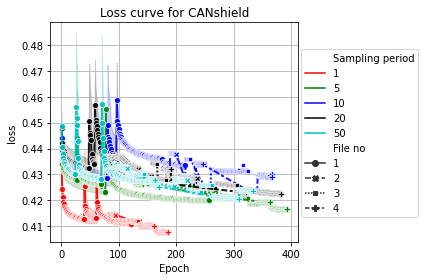

In [38]:
palette=['r', 'g', 'b', 'k', 'c'] #, 'b','k']
plt.figure(figsize=(6,4))
# sns.color_palette("viridis", as_cmap=True)
sns.lineplot(data = loss_df_final, x = 'Epoch', y = 'loss'
             , hue = 'Sampling period', style = 'File no',  linewidth = '2'
             , palette=palette[0:5], markers = True, alpha = 0.90)
plt.legend(bbox_to_anchor = (0.99, 0.9))
plt.title("Loss curve for CANshield")
plt.tight_layout()
plt.grid(True)
plt.savefig(f"plots//{dataset}//Trasfer_loss_16.jpg", dpi = 350)
plt.show()

In [39]:
loss_df_final['File no'] = loss_df_final['File no'].astype(str)
loss_df_final['Sampling period'] = loss_df_final['Sampling period'].astype(str)
loss_df_final

,loss,val_loss,Time step,Sampling period,File no,Transfer,Epoch
0,0.438247,0.449640,8,1,1,True,1
1,0.424056,0.444885,8,1,1,True,2
2,0.420345,0.442087,8,1,1,True,3
3,0.418378,0.440496,8,1,1,True,4
4,0.417181,0.439518,8,1,1,True,5
...,...,...,...,...,...,...,...
2577,0.425439,0.415920,16,50,4,False,167
2578,0.425401,0.421741,16,50,4,False,168
2579,0.425389,0.416532,16,50,4,False,169
2580,0.425324,0.416171,16,50,4,False,170


<Figure size 360x288 with 0 Axes>

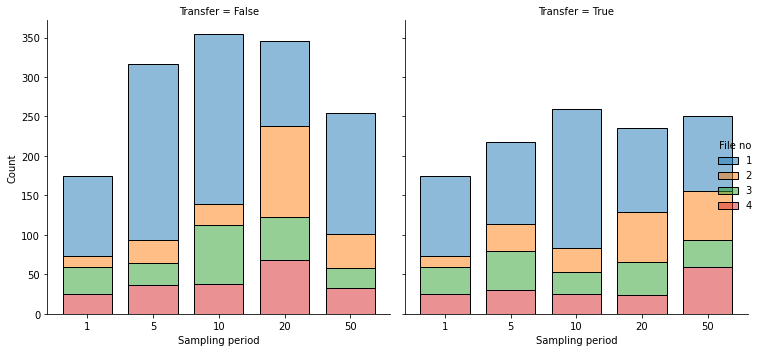

In [40]:
plt.figure(figsize=(5,4))
sns.displot(data = loss_df_final, x = 'Sampling period', stat='count'
            , hue="File no", multiple="stack", col="Transfer"
            , alpha = 0.5, shrink=.75)  #, y = 'loss', hue = 'Time step', style = 'Time step', marker = 'p')
# plt.title("Training Cost for CANSheild on SynCAN")
# plt.legend()
# plt.grid(True)
plt.ylabel("Epoch")
plt.tight_layout()
plt.savefig(f"plots//{dataset}//Trasfer_loss_cost_16.jpg", dpi = 500)
plt.show()

In [41]:
loss_df_final['Transfer'][loss_df_final['Transfer'] == True] = "With"
loss_df_final['Transfer'][loss_df_final['Transfer'] == False] = "Without"

/tmp/ipykernel_1734184/680822860.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_df_final['Transfer'][loss_df_final['Transfer'] == True] = "With"


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


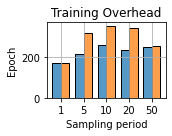

In [42]:
ts = 8
plt.figure(figsize=(2.5,2))
sns.histplot(data = loss_df_final[loss_df_final['Time step'] >= ts], x = 'Sampling period', stat='count', hue="Transfer"
             , multiple='dodge', alpha = 0.75, shrink=.75)  #, y = 'loss', hue = 'Time step', style = 'Time step', marker = 'p')
plt.title("Training Overhead")
plt.legend().set_visible(False)
plt.grid(True)
plt.ylabel("Epoch")
plt.tight_layout()
plt.savefig(f"plots//{dataset}//Trasfer_loss_cost_{ts}.jpg", dpi = 300)
plt.savefig(f"plots//{dataset}//Trasfer_loss_cost_{ts}.pdf") #, dpi = 250)
plt.show()

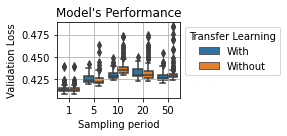

In [43]:
plt.figure(figsize=(4.0,2))
# sns.violinplot(data = loss_df_final[loss_df_final['Time step'] >= 8], x = 'Sampling period', y= 'loss', hue="Transfer", alpha = 0.75)
sns.boxplot(data = loss_df_final[loss_df_final['Time step'] >= 8], x = 'Sampling period', y= 'loss', hue="Transfer") #, alpha = 0.75)
plt.grid(True)
plt.title("Model's Performance")
plt.ylabel("Validation Loss")
plt.legend(title = "Transfer Learning", ncol = 1, bbox_to_anchor = (1,1))

plt.tight_layout()
plt.savefig(f"plots//{dataset}//Trasfer_loss_min_{ts}.jpg", dpi = 300)
plt.savefig(f"plots//{dataset}//Trasfer_loss_min_{ts}.pdf") #, dpi = 500)
plt.show()

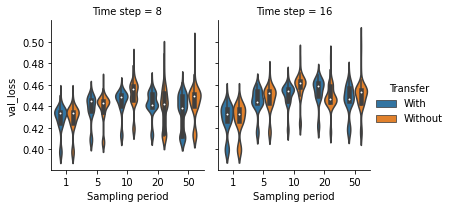

In [44]:
g = sns.catplot(x="Sampling period", y="val_loss", hue="Transfer",
                col="Time step", kind="violin", data=loss_df_final,
                height=3, aspect=.9)

In [45]:
loss_df_final_new = loss_df_final.groupby(['Time step', 'Sampling period', 'Transfer']).count()
loss_df_final_new[['Time step', 'Sampling period', 'Transfer']] =  [list(x) for x in loss_df_final_new.index]

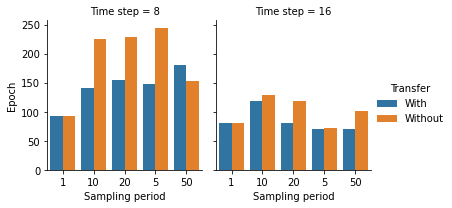

In [46]:
g = sns.catplot(x="Sampling period", y="Epoch", hue="Transfer",
                col="Time step", kind="bar", data=loss_df_final_new,
                height=3, aspect=.9)

In [47]:
loss_df_final_new = loss_df_final.groupby(['Time step', 'Sampling period', 'Transfer']).min()
loss_df_final_new[['Time step', 'Sampling period', 'Transfer']] =  [list(x) for x in loss_df_final_new.index]

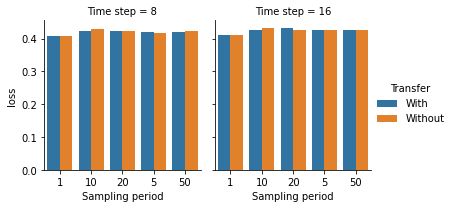

In [48]:
g = sns.catplot(x="Sampling period", y="loss", hue="Transfer",
                col="Time step", kind="bar", data=loss_df_final_new,
                height=3, aspect=.9)

------------------------ Done ------------------------
------------- Showing reconstruction example -----------
1/1 [==============================] - 0s 43ms/step


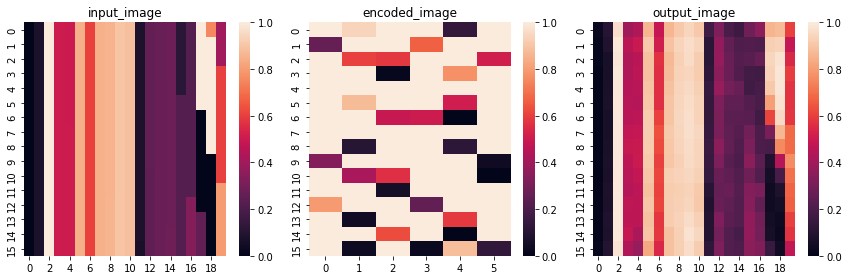

In [52]:
#-------------------------------------------------------------------
print("------------------------ Done ------------------------")

# Visualizing the training performance...........
print("------------- Showing reconstruction example -----------")
input_image = x_train_seq[1000:1001].copy()
encoded_image = encoder.predict(input_image)
output_image = decoder.predict(encoded_image)
recon_loss = np.abs(output_image - input_image)

#------- Ploting the data -------------------
fig, axes = plt.subplots(1, 3, figsize = (12, 4))

sns.heatmap(input_image[0,:,:,0], ax = axes [0], vmin = 0, vmax = 1)
axes[0].set_title("input_image")
sns.heatmap(encoded_image.reshape(16,-1), ax = axes[1], vmin = 0, vmax = 1)
axes[1].set_title("encoded_image")
sns.heatmap(output_image[0,:,:,0], ax = axes[2], vmin = 0, vmax = 1)
axes[2].set_title("output_image")
plt.tight_layout()
# plt.savefig(f"plots//{dataset}//Training_Loss_{key_key}.jpg", dpi = 350)
plt.show()
#-----------------------------------------------------

In [53]:
encoder_v2 = encoder

In [54]:
# encoder_v2.get_weights() = 0
# encoder_v2.get_weights()

In [55]:
# from tensorflow.keras.models import load_model
# sampling_period_to_look = 5
# checkpoint_path_to_look = f"AE_Models//autoendoer_canshield_{dataset}_{time_step}_{window_step}_{sampling_period_to_look}_{training_samples}.h5"
# print(checkpoint_path_to_look)
# if file_exists(checkpoint_path_to_look) or sampling_period_to_look <= 1:
#     print("We got something....")
#     try:
#         autoencoder = load_model(checkpoint_path_to_look)
#         print(f"Loading the pre-trained model...{checkpoint_path_to_look}")
#     except:
#         print("No model was found!!!!")
#         autoencoder = get_autoconder((time_step, noOfSignals, 1))
#         print("Training from the scratch.....") 
    
# else:
#     print(f"Model does not exit.")
#     sampling_period_to_look -= 5 if sampling_period_to_look > 5 else 1
#     print(f"Looking for the next model..{sampling_period_to_look}")

In [56]:
# print("We got something....")
# try:
#     autoencoder = load_model(checkpoint_path_to_look)
#     print(f"Loading the pre-trained model...{checkpoint_path_to_look}")
# except:
#     print("No model was found!!!!")
#     autoencoder = get_autoconder((time_step, noOfSignals, 1))
#     print("Training from the scratch.....")

In [57]:
# autoencoder = load_model(checkpoint_path_to_look)

In [58]:
# checkpoint_path_to_look

In [59]:
# with open(f"Saved_Data//history_{key_key}.json", "w") as outfile:
#     json.dump(history, outfile)

# autoencoder.save(checkpoint_path)

In [60]:
# autoencoder.save(checkpoint_path)

In [ ]:
# if time_step == 20:


In [ ]:
encoded.shape

In [ ]:
def Encoder():
    input_img = keras.Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format   
    e1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    e2 = MaxPooling2D((2, 2), padding='same')(e1)
    e3 = Conv2D(8, (3, 3), activation='relu', padding='same')(e2)
    e4 = MaxPooling2D((2, 2), padding='same')(e3)
    e5 = Conv2D(8, (3, 3), activation='relu', padding='same')(e4)
    e6 = MaxPooling2D((2, 2), padding='same')(e5)
    return keras.Model(input_img, e6)


def Decoder():
    input_img = keras.Input(shape=(4, 4, 8))  # adapt this if using `channels_first` image data format   
    d1 = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
    d2 = UpSampling2D((2, 2))(d1)
    d3 = Conv2D(8, (3, 3), activation='relu', padding='same')(d2)
    d4 = UpSampling2D((2, 2))(d3)
    d5 = Conv2D(16, (3, 3), activation='relu')(d4)
    d6 = UpSampling2D((2, 2))(d5)
    d7 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d6)
    return keras.Model(input_img, d7)


# define input to the model:
x = keras.Input(shape=(28, 28, 1))
# make the model:
encoder_model = Encoder()
decoder_model = Decoder()
autoencoder = keras.Model(x, decoder_model(encoder_model(x)))

# compile the model:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

In [ ]:
import keras
from keras import layers
from keras import regularizers


# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))

# # "encoded" is the encoded representation of the input
# encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# Add a Dense layer with a L1 activity regularizer
encoded = layers.Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

In [ ]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)


In [ ]:
def Encoder():
    input_img = keras.Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format   
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
#     x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
#     x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    return keras.Model(input_img, x)


def Decoder():
    input_img = keras.Input(shape=(4, 4, 8))  # adapt this if using `channels_first` image data format   
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
#     x = Conv2D(16, (3, 3), activation='relu')(x)
#     x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    return keras.Model(input_img, x)


# define input to the model:
x = keras.Input(shape=(28, 28, 1))
# make the model:
encoder_model = Encoder()
decoder_model = Decoder()
autoencoder = keras.Model(x, decoder_model(encoder_model(x)))

# compile the model:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

In [ ]:
n_filters_list = [16, 8, 8, 4]
crop_0 = ((2, 2), (2, 2))
crop_10 = ((3, 3), (2, 2))
crop_20 = ((2, 2), (2, 2))

crop_grid = crop_0

input_img = keras.Input(shape=(28, 28, 1))    
x = input_img
for n_filters in n_filters_list:    
    x = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
# x = Flatten()(x)
# x = Dense(16)(x)
encoder = keras.Model(input_img, x)


encoded_img = keras.Input(shape= x.shape[1][1:])  
x = encoded_img
# x = keras.layers.Reshape((2, 2, 4))(x)
for n_filters in n_filters_list[::-1]:    
    x = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)

x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
decoded = layers.Cropping2D(cropping= crop_grid)(x)
decoder = keras.Model(encoded_img, decoded)


# define input to the model:
x = keras.Input(shape=(28, 28, 1))
# make the model:
autoencoder = keras.Model(x, decoder(encoder(x)))

# compile the model:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

In [ ]:
input_img = keras.Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format   

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

encoder = keras.Model(input_img, x)



# adapt this if using `channels_first` image data format   
encoded_img = keras.Input(shape= x.shape[1][1:])  
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_img)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
decoder = keras.Model(encoded_img, x)


# define input to the model:
x = keras.Input(shape=(28, 28, 1))
# make the model:
autoencoder = keras.Model(x, decoder(encoder(x)))

# compile the model:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

In [ ]:
encoder.summary()

In [ ]:
decoder.summary()

In [ ]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=15,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

In [ ]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
plt.imshow(encoded_imgs[0].reshape(1,-1))

In [ ]:
plt.imshow(encoded_imgs[1].reshape(1,-1))

In [ ]:
plt.imshow(encoded_imgs[2].reshape(1,-1))

In [ ]:
plt.imshow(encoded_imgs[3].reshape(1,-1))

In [ ]:
pd.DataFrame(encoded_imgs[_ == 2]).hist()

In [ ]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
plt.plot(decoded_imgs[0])

In [ ]:
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

autoencoder = keras.Model(input_img, decoded)

# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [ ]:
encoded

In [ ]:
encoded.shape[1][1:]

In [ ]:
input_img

In [ ]:
encoder = keras.Model(input_img, encoded)
encoder.summary()

In [ ]:
encoded.shape[1]

In [ ]:
decoder = keras.Model(encoded.shape, decoded)
decoder.summary()

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

In [ ]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

In [ ]:
input_img

In [ ]:
encoder = keras.Model(input_img, encoded)
encoder.summary()

In [ ]:
input_img_d = keras.Input(shape= (4,4,8))
input_img_d

In [ ]:
autoencoder.layers[7:]

In [ ]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(4,4,8,))

# Retrieve the last layer of the autoencoder model
# decoder_layer = autoencoder.layers[7:]
# Create the decoder model
decoder = keras.Model(encoded_input, decoded)
decoder.summary()

In [ ]:
decoder_layer